<h1 align=center><font size = 5>Segmenting and Clustering Neighborhoods in Toronto</font></h1>



**Table of the contents**

**1.1 Create the Neighborhoods dataframe**

**1.2 Update the Neighborhood dataframe with geospatial data**

**1.3 Explore the neighborhoods in Toronto**

**1.4 Clustering and analyzing the clusters**

In [1]:
import pandas as pd
pd.set_option('display.max_columns', 10) #for easiness of reading
pd.set_option('display.max_rows', None)

import numpy as np
!pip install lxml #parser to read html

!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim

import requests 

#!conda install -c conda-forge folium=0.5.0 --yes
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.cluster import KMeans

     |████████████████████████████████| 5.5MB 5.5MB/s eta 0:00:01
Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-2.0.0                |     pyh9f0ad1d_0          63 KB  conda-forge
    ------------------------------------------------------------
                                           Total:          97 KB

The following NEW packages will be INSTALLED:

  geographiclib      conda-forge/noarch::geographiclib-1.50-py_0
  geopy              conda-forge/noarch::geopy-2.0.0-pyh9f0ad1d_0



geopy-2.0.0          | 63 KB     | ##################################### | 100% 
geographiclib-1.50   | 34 KB     | ##################################### | 100% 
Preparing tran

## Create the Neighborhoods dataframe

**I used Pandas to scrap the table from the Wikipedia page.**


In [2]:
#scrap html table from https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M using Pandas
ls = pd.read_html('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M',flavor='lxml')
df=pd.DataFrame(ls[0])
df.head()

,Post Code,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


Verifying basic info:

In [3]:
#check basic info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180 entries, 0 to 179
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Post Code     180 non-null    object
 1   Borough       180 non-null    object
 2   Neighborhood  180 non-null    object
dtypes: object(3)
memory usage: 4.3+ KB


**Running some basic preparations.**

The dataframe will consist of three columns: PostalCode, Borough, and Neighborhood.

In [4]:
#renaming comumn
df.rename(columns = {'Post Code':'PostalCode'}, inplace = True)

Only process the cells that have an assigned borough:

In [5]:
#removing rows where Borough is not assigned
df=df.loc[df['Borough']!='Not assigned',:]

Make sure that there aren't un-assigned neighborhoods, otherwise the neighborhood will be the same as the borough:

In [6]:
#verifying if there are not assigned neighborhoods: NO
len(df.loc[df['Neighborhood'].str.contains('Not assigned'),:])

0

Make sure that more than one neighborhood can exist in one postal code area, otherwise these rows will be combined into one row with the neighborhoods separated with a comma:

In [7]:
#verifying if multiple neighborhoods exists for the same postal code area: NO
df_grouped = df.groupby(['PostalCode']).count()
len(df_grouped[df_grouped['Neighborhood']>1])

0

Sort the dataframe and reset the index:

In [8]:
#sorting the dataframe and resetting index
df.sort_values('PostalCode',inplace=True)
df.reset_index(drop=True,inplace=True)

**You can see below the Neighborhood dataframe, which is required in step 1, and its shape found using the shape method.**

In [9]:
#dataframe scrapped and formatted
df.head()

,PostalCode,Borough,Neighborhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [10]:
print('The shape of the dataframe is:',df.shape)

The shape of the dataframe is: (103, 3)


## Update the Neighborhood dataframe with geospatial data

**Downloading the geospatial data from the csv file.**

I found the Geocoder package to be un-reliable so I decided to use the cvs file.

In [11]:
#download latitude and longitude table
df_latlon = pd.read_csv('https://cocl.us/Geospatial_data')
#rename comumn
df_latlon.rename(columns = {'Postal Code':'PostalCode'}, inplace = True)
print('The size of the geospatial dataframe is:',df_latlon.shape,'\n')
df_latlon.head()

The size of the geospatial dataframe is: (103, 3) 



,PostalCode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


**Merging the Neighborhood dataframe with the geospatial dataframe: you can see below the dataframe which is requested in step 2.**

In [12]:
#Merge the postal codes dataframe with the geospatial data table
df_merged=df.join(df_latlon.set_index('PostalCode'),on='PostalCode')
#sort the dataframe
df_merged.sort_values('PostalCode',inplace=True)
#reset the index
df_merged.reset_index(drop=True, inplace=True)
print('The size of the merged dataframe is:',df_merged.shape,'\n')
df_merged.head()

The size of the merged dataframe is: (103, 5) 



,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


In [13]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(len(df_merged['Borough'].unique()),df_merged.shape[0]))

The dataframe has 10 boroughs and 103 neighborhoods.


## Explore and cluster the neighborhoods in Toronto

**Create a map with all the Toronto neighborhoods superimposed on top**

In [14]:
#finding the latitude and longitude for Toronto
address = 'Toronto, Ontario, Canada'

geolocator = Nominatim(user_agent="Toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


In [15]:
# create map of Toronto using latitude and longitude values
map_Toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_merged['Latitude'], df_merged['Longitude'], df_merged['Borough'], df_merged['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Toronto)  
    
map_Toronto

**Exploring the data**

In [16]:
#checking how many neighborhoods in each borough
df_merged['Borough'].value_counts()

North York          24
Downtown Toronto    19
Scarborough         17
Etobicoke           12
Central Toronto      9
West Toronto         6
York                 5
East York            5
East Toronto         5
Mississauga          1
Name: Borough, dtype: int64

**Based on the above list, I slice the dataframe to exclude Mississauga:**

In [17]:
# I select the boroughs and slice the dataframe
df_Toronto = df_merged[df_merged['Borough']!='Mississauga'].reset_index(drop=True)
df_Toronto.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


In [18]:
print('The dataframe for the City of Toronto has {} boroughs and {} neighborhoods.'.format(len(df_Toronto['Borough'].unique()),df_Toronto.shape[0]))

The dataframe for the City of Toronto has 9 boroughs and 102 neighborhoods.


Create a map with neighborhoods from the sliced dataframe superimposed on top:

In [19]:
# create map of Toronto using latitude and longitude values
map_Toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_Toronto['Latitude'], df_Toronto['Longitude'], df_Toronto['Borough'], df_Toronto['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Toronto)  
    
map_Toronto

**Using Foursquare to retrieve the top 100 venues in the range of 500 m from each neighborood.**

Setup the credentials:

In [20]:
#setup the credentials to use Foursquare
CLIENT_ID = 'XVDNOAMFQKJXJNJ25Q2VBYWILOIKR02VHEYGCM0VDACQW2L0' # your Foursquare ID
CLIENT_SECRET = 'C5WAKNFXTFCH3NYY3Y30J4V4GYG1JPHEWNEQOVJU3UPHFKXO' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('My credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

My credentails:
CLIENT_ID: XVDNOAMFQKJXJNJ25Q2VBYWILOIKR02VHEYGCM0VDACQW2L0
CLIENT_SECRET:C5WAKNFXTFCH3NYY3Y30J4V4GYG1JPHEWNEQOVJU3UPHFKXO


Function which returns all the venues for each neighborhood:

In [24]:
#function which returns all the venues in a dataframe
#the radius and limit to search around each neighborhood are reasonable
radius = 500
LIMIT = 100

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)
Toronto_venues.head()

**Toronto_venues is the dataframe with all the Neighborhoods and their venues:**

In [25]:
Toronto_venues = getNearbyVenues(names=df_Toronto['Neighborhood'],
                                   latitudes=df_Toronto['Latitude'],
                                   longitudes=df_Toronto['Longitude']
                                  )
print('Nearby venues imported','\n')

Malvern, Rouge
Rouge Hill, Port Union, Highland Creek
Guildwood, Morningside, West Hill
Woburn
Cedarbrae
Scarborough Village
Kennedy Park, Ionview, East Birchmount Park
Golden Mile, Clairlea, Oakridge
Cliffside, Cliffcrest, Scarborough Village West
Birch Cliff, Cliffside West
Dorset Park, Wexford Heights, Scarborough Town Centre
Wexford, Maryvale
Agincourt
Clarks Corners, Tam O'Shanter, Sullivan
Milliken, Agincourt North, Steeles East, L'Amoreaux East
Steeles West, L'Amoreaux West
Upper Rouge
Hillcrest Village
Fairview, Henry Farm, Oriole
Bayview Village
York Mills, Silver Hills
Willowdale, Newtonbrook
Willowdale, Willowdale East
York Mills West
Willowdale, Willowdale West
Parkwoods
Don Mills
Don Mills
Bathurst Manor, Wilson Heights, Downsview North
Northwood Park, York University
Downsview
Downsview
Downsview
Downsview
Victoria Village
Parkview Hill, Woodbine Gardens
Woodbine Heights
The Beaches
Leaside
Thorncliffe Park
East Toronto, Broadview North (Old East York)
The Danforth West, 

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Malvern, Rouge",43.806686,-79.194353,Wendy’s,43.807448,-79.199056,Fast Food Restaurant
1,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,Great Shine Window Cleaning,43.783145,-79.157431,Home Service
2,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar
3,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,Affordable Toronto Movers,43.787919,-79.162977,Moving Target
4,"Guildwood, Morningside, West Hill",43.763573,-79.188711,RBC Royal Bank,43.766790,-79.191151,Bank


I found a 'Neighborhood' venue category:

In [26]:
Toronto_venues[Toronto_venues['Venue Category'].str.contains('Neighborhood')]

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
298,The Beaches,43.676357,-79.293031,Upper Beaches,43.680563,-79.292869,Neighborhood
428,Studio District,43.659526,-79.340923,Leslieville,43.662070,-79.337856,Neighborhood
1025,"Richmond, Adelaide, King",43.650571,-79.384568,Downtown Toronto,43.653232,-79.385296,Neighborhood
1117,"Harbourfront East, Union Station, Toronto Islands",43.640816,-79.381752,Harbourfront,43.639526,-79.380688,Neighborhood


I removed the rows which include the category 'Neighborhood':

In [27]:
#remove venues which include the category 'Neighborhood'
Toronto_venues=Toronto_venues[~Toronto_venues['Venue Category'].str.contains('Neighborhood')]
Toronto_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Malvern, Rouge",43.806686,-79.194353,Wendy’s,43.807448,-79.199056,Fast Food Restaurant
1,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,Great Shine Window Cleaning,43.783145,-79.157431,Home Service
2,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar
3,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,Affordable Toronto Movers,43.787919,-79.162977,Moving Target
4,"Guildwood, Morningside, West Hill",43.763573,-79.188711,RBC Royal Bank,43.766790,-79.191151,Bank


In [28]:
Toronto_venues.shape

(2117, 7)

**Toronto_onehot is the hot encoded dataframe which I need to review the most common venues for each Neighborhood:**

In [61]:
# one hot encoding
Toronto_onehot = pd.get_dummies(Toronto_venues[['Venue Category']], prefix="", prefix_sep="")

In [62]:
# add neighborhood column back to dataframe and move it to the first column

Toronto_onehot['Neighborhood'] = Toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [Toronto_onehot.columns[-1]] + list(Toronto_onehot.columns[:-1])
Toronto_onehot = Toronto_onehot[fixed_columns]

Toronto_onehot.head()

,Neighborhood,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,...,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,"Malvern, Rouge",0,0,0,0,...,0,0,0,0,0
1,"Rouge Hill, Port Union, Highland Creek",0,0,0,0,...,0,0,0,0,0
2,"Rouge Hill, Port Union, Highland Creek",0,0,0,0,...,0,0,0,0,0
3,"Rouge Hill, Port Union, Highland Creek",0,0,0,0,...,0,0,0,0,0
4,"Guildwood, Morningside, West Hill",0,0,0,0,...,0,0,0,0,0


In [63]:
Toronto_onehot.shape

(2117, 271)

**Toronto grouped is the dataframe which I will need in the next steps and for clustering:**

In [64]:
#group by neighborhoods
Toronto_grouped = Toronto_onehot.groupby('Neighborhood').mean().reset_index()
Toronto_grouped.head()

,Neighborhood,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,...,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Agincourt,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0
1,"Alderwood, Long Branch",0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0
2,"Bathurst Manor, Wilson Heights, Downsview North",0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0
3,Bayview Village,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0
4,"Bedford Park, Lawrence Manor East",0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0


In [65]:
Toronto_grouped.shape

(93, 271)

**Showing the top 5 most common venues for each neighborhood:**

In [66]:
#create the function to sort the venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [67]:
#return the 5 most common venues for each neighborhood
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Toronto_grouped['Neighborhood']

for ind in np.arange(Toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Agincourt,Skating Rink,Lounge,Breakfast Spot,Latin American Restaurant,Doner Restaurant
1,"Alderwood, Long Branch",Pizza Place,Gym,Athletics & Sports,Coffee Shop,Pub
2,"Bathurst Manor, Wilson Heights, Downsview North",Coffee Shop,Bank,Pizza Place,Fried Chicken Joint,Pharmacy
3,Bayview Village,Café,Japanese Restaurant,Bank,Chinese Restaurant,Deli / Bodega
4,"Bedford Park, Lawrence Manor East",Sandwich Place,Coffee Shop,Italian Restaurant,Restaurant,Pharmacy


## Clustering and analyzing the clusters

Drop the column Neighborhood to prepare for clustering:

In [68]:
# drop the Neighborhood column
Toronto_grouped_clustering = Toronto_grouped.drop('Neighborhood', 1)

Using GridsearchCV to find the best parameters:

In [69]:
from sklearn.model_selection import GridSearchCV

clfKM=KMeans()
params={'init':['k-means++','random'],'n_clusters':[3,5,7],'random_state':[0,1]}
grid = GridSearchCV(estimator = clfKM,param_grid=params,cv=10)
grid.fit(Toronto_grouped_clustering)
grid.best_params_

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'init': 'random', 'n_clusters': 7, 'random_state': 0}

Finding the best number of clusters using the elbow method and the inertia_ attribute which measures the sum of squared distances of samples to their closest cluster center:

1 : 19.022954283122115
2 : 16.95857948499928
3 : 15.713857206129141
4 : 15.377896146827636
5 : 14.462984078542721
6 : 14.028741882061277


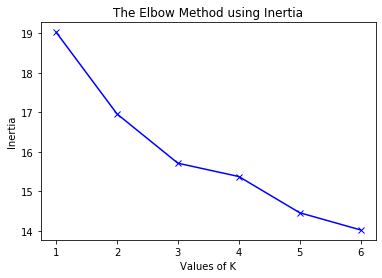

In [71]:
# importing the required libraries
from sklearn import metrics 
from scipy.spatial.distance import cdist 
import matplotlib.pyplot as plt 

distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(1,7) 

X = Toronto_grouped_clustering
  
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(init = 'random', n_clusters = k, random_state=0).fit(X) 
    kmeanModel.fit(X)     
      
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / X.shape[0]) 
    inertias.append(kmeanModel.inertia_) 
 
    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / X.shape[0] 
    mapping2[k] = kmeanModel.inertia_ 

#for key,val in mapping1.items(): 
#    print(str(key)+' : '+str(val))
    
#plt.plot(K, distortions, 'bx-') 
#plt.xlabel('Values of K') 
#plt.ylabel('Distortion') 
#plt.title('The Elbow Method using Distortion') 
#plt.show()

for key,val in mapping2.items(): 
    print(str(key)+' : '+str(val))

plt.plot(K, inertias, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 
plt.show()


Setting the number of clusters and running KMeans. I decide to go with 3 clusters:

In [72]:
# set number of clusters
kclusters = 3

# run k-means clustering
kmeans = KMeans(init = 'random', n_clusters = kclusters, random_state=0)
kmeans.fit(Toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

Adding the cluster labels:

In [73]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

Toronto_merged = df_Toronto

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
Toronto_merged = Toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood',how='right') # right join

Toronto_merged.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude,...,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353,...,Fast Food Restaurant,Yoga Studio,Doner Restaurant,Dessert Shop,Dim Sum Restaurant
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,...,Moving Target,Bar,Home Service,Deli / Bodega,Dessert Shop
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,...,Intersection,Restaurant,Electronics Store,Medical Center,Breakfast Spot
3,M1G,Scarborough,Woburn,43.770992,-79.216917,...,Coffee Shop,Korean Restaurant,Yoga Studio,Dog Run,Dessert Shop
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,...,Hakka Restaurant,Gas Station,Bakery,Bank,Athletics & Sports


Verifying that there aren't null labels:

In [74]:
#verify that the join didn't leave rows with a NaN label
len(Toronto_merged[Toronto_merged['Cluster Labels'].isna()])

0

**Creating a map of the clusters.**

In [75]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Toronto_merged['Latitude'], Toronto_merged['Longitude'], Toronto_merged['Neighborhood'], Toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

**Showing the details of each cluster: cluster 0 is the largest and it's dominated by restaurants and lifestyle locations, cluster 1 features outdoor venues and facilities, cluster 2 is the smallest**

In [76]:
Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 0, Toronto_merged.columns[[1,2]+ list(range(5, Toronto_merged.shape[1]))]]

,Borough,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Scarborough,"Malvern, Rouge",0,Fast Food Restaurant,Yoga Studio,Doner Restaurant,Dessert Shop,Dim Sum Restaurant
1,Scarborough,"Rouge Hill, Port Union, Highland Creek",0,Moving Target,Bar,Home Service,Deli / Bodega,Dessert Shop
2,Scarborough,"Guildwood, Morningside, West Hill",0,Intersection,Restaurant,Electronics Store,Medical Center,Breakfast Spot
3,Scarborough,Woburn,0,Coffee Shop,Korean Restaurant,Yoga Studio,Dog Run,Dessert Shop
4,Scarborough,Cedarbrae,0,Hakka Restaurant,Gas Station,Bakery,Bank,Athletics & Sports
5,Scarborough,Scarborough Village,0,Playground,Dog Run,Department Store,Dessert Shop,Dim Sum Restaurant
6,Scarborough,"Kennedy Park, Ionview, East Birchmount Park",0,Department Store,Bus Station,Coffee Shop,Hobby Shop,Dog Run
7,Scarborough,"Golden Mile, Clairlea, Oakridge",0,Bakery,Soccer Field,Park,Ice Cream Shop,Bus Station
8,Scarborough,"Cliffside, Cliffcrest, Scarborough Village West",0,American Restaurant,Motel,Yoga Studio,Dessert Shop,Dim Sum Restaurant
9,Scarborough,"Birch Cliff, Cliffside West",0,General Entertainment,College Stadium,Café,Skating Rink,Yoga Studio


In [77]:
Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 1, Toronto_merged.columns[[1,2]+ list(range(5, Toronto_merged.shape[1]))]]

,Borough,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
14,Scarborough,"Milliken, Agincourt North, Steeles East, L'Amo...",1,Playground,Park,Dog Run,Department Store,Dessert Shop
23,North York,York Mills West,1,Park,Convenience Store,Yoga Studio,Dessert Shop,Dim Sum Restaurant
25,North York,Parkwoods,1,Park,Food & Drink Shop,Yoga Studio,Dog Run,Dessert Shop
40,East York,"East Toronto, Broadview North (Old East York)",1,Park,Convenience Store,Metro Station,Doner Restaurant,Dessert Shop
44,Central Toronto,Lawrence Park,1,Park,Bus Line,Swim School,Yoga Studio,Distribution Center
50,Downtown Toronto,Rosedale,1,Park,Playground,Trail,Discount Store,Deli / Bodega
64,Central Toronto,"Forest Hill North & West, Forest Hill Road Park",1,Park,Sushi Restaurant,Jewelry Store,Trail,Yoga Studio
74,York,Caledonia-Fairbanks,1,Park,Women's Store,Pool,Dog Run,Department Store
79,North York,"North Park, Maple Leaf Park, Upwood Park",1,Basketball Court,Bakery,Park,Construction & Landscaping,Yoga Studio
89,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North",1,Park,River,Yoga Studio,Distribution Center,Department Store


In [78]:
Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 2, Toronto_merged.columns[[1,2]+ list(range(5, Toronto_merged.shape[1]))]]

,Borough,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
90,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu...",2,Pool,Baseball Field,Yoga Studio,Dog Run,Dessert Shop
96,North York,"Humberlea, Emery",2,Baseball Field,Yoga Studio,Dessert Shop,Dim Sum Restaurant,Diner
